In [ ]:
# $ conda env list
# # conda environments:
# #
# base                  *  /g/data1a/ha3/fxz547/miniconda3
# py37                     /g/data1a/ha3/fxz547/miniconda3/envs/py37


# (base) fxz547@vdi-n11 /g/data1a/ha3/fxz547/Githubz/passive-seismic/seismic/ml_classifier (fei/py3aws)
# $ conda activate py37

In [1]:
from keras import backend

Using Theano backend.


In [2]:
import os
from random import shuffle,seed

def build_input_data(data_folder):
    """build a list of IDs and dictionary of labels
    """
    files=os.listdir(data_folder)
    IDs=[]
    for fname in files:
        if fname.endswith('.npy'):
            IDs.append(fname.rstrip('.npy'))

    labels={}
    Sctr=0
    Nctr=0
    for ID in IDs:
        if ID.endswith('_S'):
            labels[ID]=0
            Sctr+=1
        else:
            labels[ID]=1
            Nctr+=1

    seed(0)
    shuffle(IDs)
    trainLen=int(0.8*len(IDs))#use 80% of the data as training set
    valLen=int(0.1*len(IDs))
    partition={}
    partition['train'],partition['val'],partition['test']=IDs[0:trainLen],IDs[trainLen:trainLen+valLen],IDs[trainLen+valLen:]


    #create ID lists for S, N wave test cases

    inv_labels=[[],[]]
    for ID in partition['test']:
        inv_labels[labels[ID]].append(ID)

    print('dataset contains '+str(Sctr)+' S waves and '+str(Nctr)+' noise waveforms.')
    print('training set contains '+str(len(partition['train']))+' waveforms and test set contains '+str(len(partition['test']))+' waveforms.')
    
    return partition



In [3]:
wave_data_folder='/g/data/ha3/fxz547/seiswave_data_4ml'

ds_parts=build_input_data(wave_data_folder)

print (ds_parts.keys())

dataset contains 28499 S waves and 28505 noise waveforms.
training set contains 45603 waveforms and test set contains 5701 waveforms.
dict_keys(['train', 'val', 'test'])


In [4]:
import data

SIDs=data.getIDs(0)
NIDs=data.getIDs(1)

print (SIDs[:10])
print(NIDs[:10])

dataset contains 28499 S waves and 28505 noise waveforms.
training set contains 45603 waveforms and test set contains 5701 waveforms.
['30198_S', '3677_S', '21174_S', '17812_S', '1636_S', '24551_S', '27429_S', '11643_S', '25584_S', '22208_S']
['1603_N', '25224_N', '3369_N', '16908_N', '22300_N', '33828_N', '19070_N', '26563_N', '11512_N', '19553_N']


In [5]:
import numpy as np
npyfile = "/g/data/ha3/fxz547/seiswave_data_4ml/3996_S.npy"
my_waved= np.load(npyfile)

In [6]:
print (type(my_waved))

<class 'numpy.ndarray'>


In [7]:
import xarray as xar

xa = xar.DataArray(my_waved, dims=['wamplitude'])


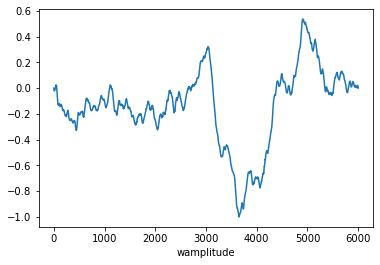

In [10]:
xa.plot()

In [9]:
xa

<xarray.DataArray (wamplitude: 6000)>
array([ 0.      , -0.006568, -0.011815, ...,  0.011536,  0.006559,  0.      ])
Dimensions without coordinates: wamplitude

# Predict Phase Using a Trained Model

In [11]:
from model import shakenet
#from data import *
import data
import os
import matplotlib
matplotlib.use('Agg')
import obspy.core as oc

model=shakenet(pretrained_weights='shakenet-model.hdf5')


#dataDir='/g/data/ha3/rlt118/neural-datasets/categoriser-teleseismic/'
dataDir= data.datafolder  #'/g/data/ha3/fxz547/seiswave_data_4ml'
SIDs=data.getIDs(0)
NIDs=data.getIDs(1)

for ID in SIDs[:1]:
    x=np.resize(np.load(os.path.join(dataDir,ID+'.npy')),(1,6002,1))
    result=model.predict(x,batch_size=1)
    
    print (result)
    
    if np.argmax(result[0])==0:
        outfname='correctS/'+ID+'.png'
    else:
        outfname='badS-N/'+ID+'.png'
        
    trc=oc.stream.read(os.path.join(dataDir,ID+'.pkl'),  format="PICKLE")
        
    print("writing outfile", outfname)
    
    trc.plot(outfile=outfname)

for ID in NIDs[:1]:
    x=np.resize(np.load(os.path.join(dataDir,ID+'.npy')),(1,6002,1))
    result=model.predict(x,batch_size=1)
    print (result)
    
    trc=oc.stream.read(os.path.join(dataDir,ID+'.pkl'), format="PICKLE")
    if np.argmax(result[0])==0:
        outfname='badN-S/'+ID+'.png'
    else:
        outfname='correctN/'+ID+'.png'
        
    print("writing outfile", outfname) 
    trc.plot(outfile=outfname)


/g/data1a/ha3/fxz547/Githubz/passive-seismic/seismic/ml_classifier/model.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=Softmax.0)`
  model = Model(input = inputs, output = dense5)
/g/data1a/ha3/fxz547/miniconda3/envs/py37/lib/python3.7/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


[[ 0.81007814  0.18992187]]
writing outfile correctS/30198_S.png
[[ 0.00302994  0.99697006]]
writing outfile correctN/1603_N.png
